## PDSPL Analysis
Author: Paras Sharma

This notebook aims to explore the following:

1. Let's say for a **deflector** we only had measurements of half light radii, redshift, and avg. lensing mass density within half the effective radii. How much scatter would we expect in the velocity dispersion of deflectors? Further how does this scatter influence the error in einstein radius ratio?

2. If we could constrain the velocity dispersion independently of the above measurements, how much would this reduce the error in the einstein radius ratio?


Some variables:

- $\theta_E^{D1, S1}$: Einstein radius of deflector 1 + source 1 system
- $\theta_E^{D2, S1}$: Einstein radius of deflector 2 + source 1 system
- $\theta_E^{D2, S2}$: Einstein radius of deflector 2 + source 2 system
- $\sigma_{v, D1}$: Velocity dispersion of deflector 1
- $\sigma_{v, D2}$: Velocity dispersion of deflector 2
- $R_{e, D1}$: Effective radius of deflector 1
- $R_{e, D2}$: Effective radius of deflector 2
- $\Sigma_{1/2, D1}$: Average lensing mass density within 1/2 * effective radius of deflector 1
- $\Sigma_{1/2, D2}$: Average lensing mass density within 1/2 * effective radius of deflector 2
- $z_{S1}$: Redshift of source 1
- $z_{S2}$: Redshift of source 2
- $z_{D1}$: Redshift of deflector 1
- $z_{D2}$: Redshift of deflector 2

- $\beta_E = \frac{\theta_E^{D1, S1}}{\theta_E^{D2, S2}}$: Einstein radius ratio of deflector 1 + source 1 system to deflector 2 + source 2 system. This is the quantity we will observe.
- $\beta_{E, DSPL, D1} = \frac{\theta_E^{D1, S1}}{\theta_E^{D1, S2}}$: Einstein radius ratio of source 1 system to source 2 when both sources are lensed by deflector 1.
- $\beta_{E, DSPL, D2} = \frac{\theta_E^{D2, S1}}{\theta_E^{D2, S2}}$: Einstein radius ratio of source 1 system to source 2 when both sources are lensed by deflector 2.
- $\mathcal{N}^2 = |\beta_E - \beta_{E, DSPL, D1}|^2 + |\beta_E - \beta_{E, DSPL, D2}|^2$: Total squared difference between the observed and predicted Einstein radius ratios.

Relative errors:

- $\frac{\Delta \beta_E}{\beta_E} = \frac{1}{2} \left( \frac{|\beta_E - \beta_{E, DSPL, D1}|}{\beta_E} + \frac{|\beta_E - \beta_{E, DSPL, D2}|}{\beta_E} \right) = \frac{1}{2} \left( \left|1 - \frac{\beta_{E, DSPL, D1}}{\beta_E}\right| + \left|1 - \frac{\beta_{E, DSPL, D2}}{\beta_E}\right| \right)$ : Error in the observed Einstein radius ratio when two single source plane lenses are interpreted as a double source plane lens.

- $\frac{\Delta \sigma_{v, D}}{\sigma_{v, D}} = 2 \frac{|\sigma_{v, D1} - \sigma_{v, D2}|}{\sigma_{v, D1} + \sigma_{v, D2}}$ : Relative error in the velocity dispersion of avg. deflector D when two deflectors are interpreted as a single deflector.

For a singular isothermal sphere (SIS) lens: $\theta_E \propto {\sigma_v}^2$
$$\Rightarrow \frac{\Delta \theta_E}{\theta_E} = 2 \frac{\Delta \sigma_v}{\sigma_v}$$
$$\beta_E = \frac{\theta_E^{D1, S1}}{\theta_E^{D2, S2}}$$
$$\Rightarrow \frac{\Delta \beta_E}{\beta_E} = \frac{\Delta \theta_E^{D1, S1}}{\theta_E^{D1, S1}} + \frac{\Delta \theta_E^{D2, S2}}{\theta_E^{D2, S2}} = 2 \left[\frac{\Delta \sigma_{v, D1}}{\sigma_{v, D1}} + \frac{\Delta \sigma_{v, D2}}{\sigma_{v, D2}}\right]$$

In [1]:
# Standard imports
import copy
import corner
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Astropy imports
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.units import Quantity
from astropy import constants as const

# SLSim imports
import slsim.Pipelines as pipelines
import slsim.Sources as sources
import slsim.Deflectors as deflectors
from slsim.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots
from slsim.lens import Lens
from slsim.LOS.los_pop import LOSPop

# Lenstronomy, HierArc imports
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

# set global plotting parameters for academic paper
# plt.rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 14,
#     "axes.titlesize": 14,
#     "xtick.labelsize": 12,
#     "ytick.labelsize": 12,
#     "legend.fontsize": 12,
#     "figure.titlesize": 16,
#     "figure.figsize": (8, 6),
#     "lines.linewidth": 1.5,
#     "lines.markersize": 6,
#     "font.family": "serif",
#     "text.usetex": True,
# })

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Plots/lens_plots.py:5: UserWarning: If you want to simulate images with Roman filters, please install the galsim module.
Note that this module is not supported on Windows
  from slsim.roman_image_simulation import simulate_roman_image


In [2]:
# Fit plane to the data
def fit_plane(x, y, z):
    """Fit a plane to the data points (x, y, z). The plane is z = ax + by + c."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    A = np.c_[x, y, np.ones_like(x)]
    coeffs, _, _, _ = np.linalg.lstsq(A, z, rcond=None)
    return coeffs

# Find the scatter of the data points from the fitted plane
def find_scatter(x, y, z, coeffs, return_fit=False):
    """Find the scatter of the data points from the fitted plane. Return ``z - z_fit``."""

    # don't use nans or infs
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x = x[mask]
    y = y[mask]
    z = z[mask]

    z_fit = coeffs[0] * x + coeffs[1] * y + coeffs[2]
    scatter = z - z_fit
    if return_fit:
        return scatter, z_fit
    else:
        return scatter

## Generate SLSim Catalog

In [3]:
# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# define a sky area
sky_area_galaxies = Quantity(value=30, unit="deg2")
sky_area_source = Quantity(value=30, unit="deg2")  # sky area of the source population
sky_area_deflector = Quantity(value=30, unit="deg2")  # sky area of the deflector population
sky_area_lens = Quantity(value=30, unit="deg2")  # sky area of the lens population


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area_galaxies, filters=None, cosmo=cosmo_true
)

# Initiate deflector population class.
# lens_galaxies = deflectors.AllLensGalaxies(
#     red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
#     blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
#     kwargs_cut=kwargs_deflector_cut,
#     kwargs_mass2light=None,
#     cosmo=cosmo_true,
#     sky_area=sky_area_deflector,
# )
lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo_true,
    sky_area=sky_area_deflector,
    # gamma_pl=2.1, by default it is set to 2.0
)

# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo_true,
    sky_area=sky_area_source,
    catalog_type="skypy",
)

# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo_true,
    sky_area=sky_area_lens,
    los_pop=LOSPop(los_bool=False),  # no line-of-sight population
)

# make lensplot class for extracting rgb images
gg_plot = LensingPlots(gg_lens_pop, num_pix=100, coadd_years=10)

print(f"LensPop initialized. Potential deflectors: {gg_lens_pop.deflector_number} ; Potential sources: {gg_lens_pop.source_number}");

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SL Research/codes/repos/self/slsim/slsim/Deflectors/elliptical_lens_galaxies.py:46: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


LensPop initialized. Potential deflectors: 757936 ; Potential sources: 14240329


In [4]:
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
# kwargs_lens_cut = {}
selected_lenses = gg_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cut,
)

# selected_lenses = []
# num_lenses = 5000  # Number of lenses to select

# for i in tqdm(range(num_lenses)):
#     try:
#         selected_lenses.append(
#         gg_lens_pop.select_lens_at_random()
#     )
#     except Exception as e:
#         print(f"Error drawing lens {i}: {e}")


# Print the number of selected lenses
print(f"Number of selected lenses: {len(selected_lenses)}")

/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/lenstronomy/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


Number of selected lenses: 2782


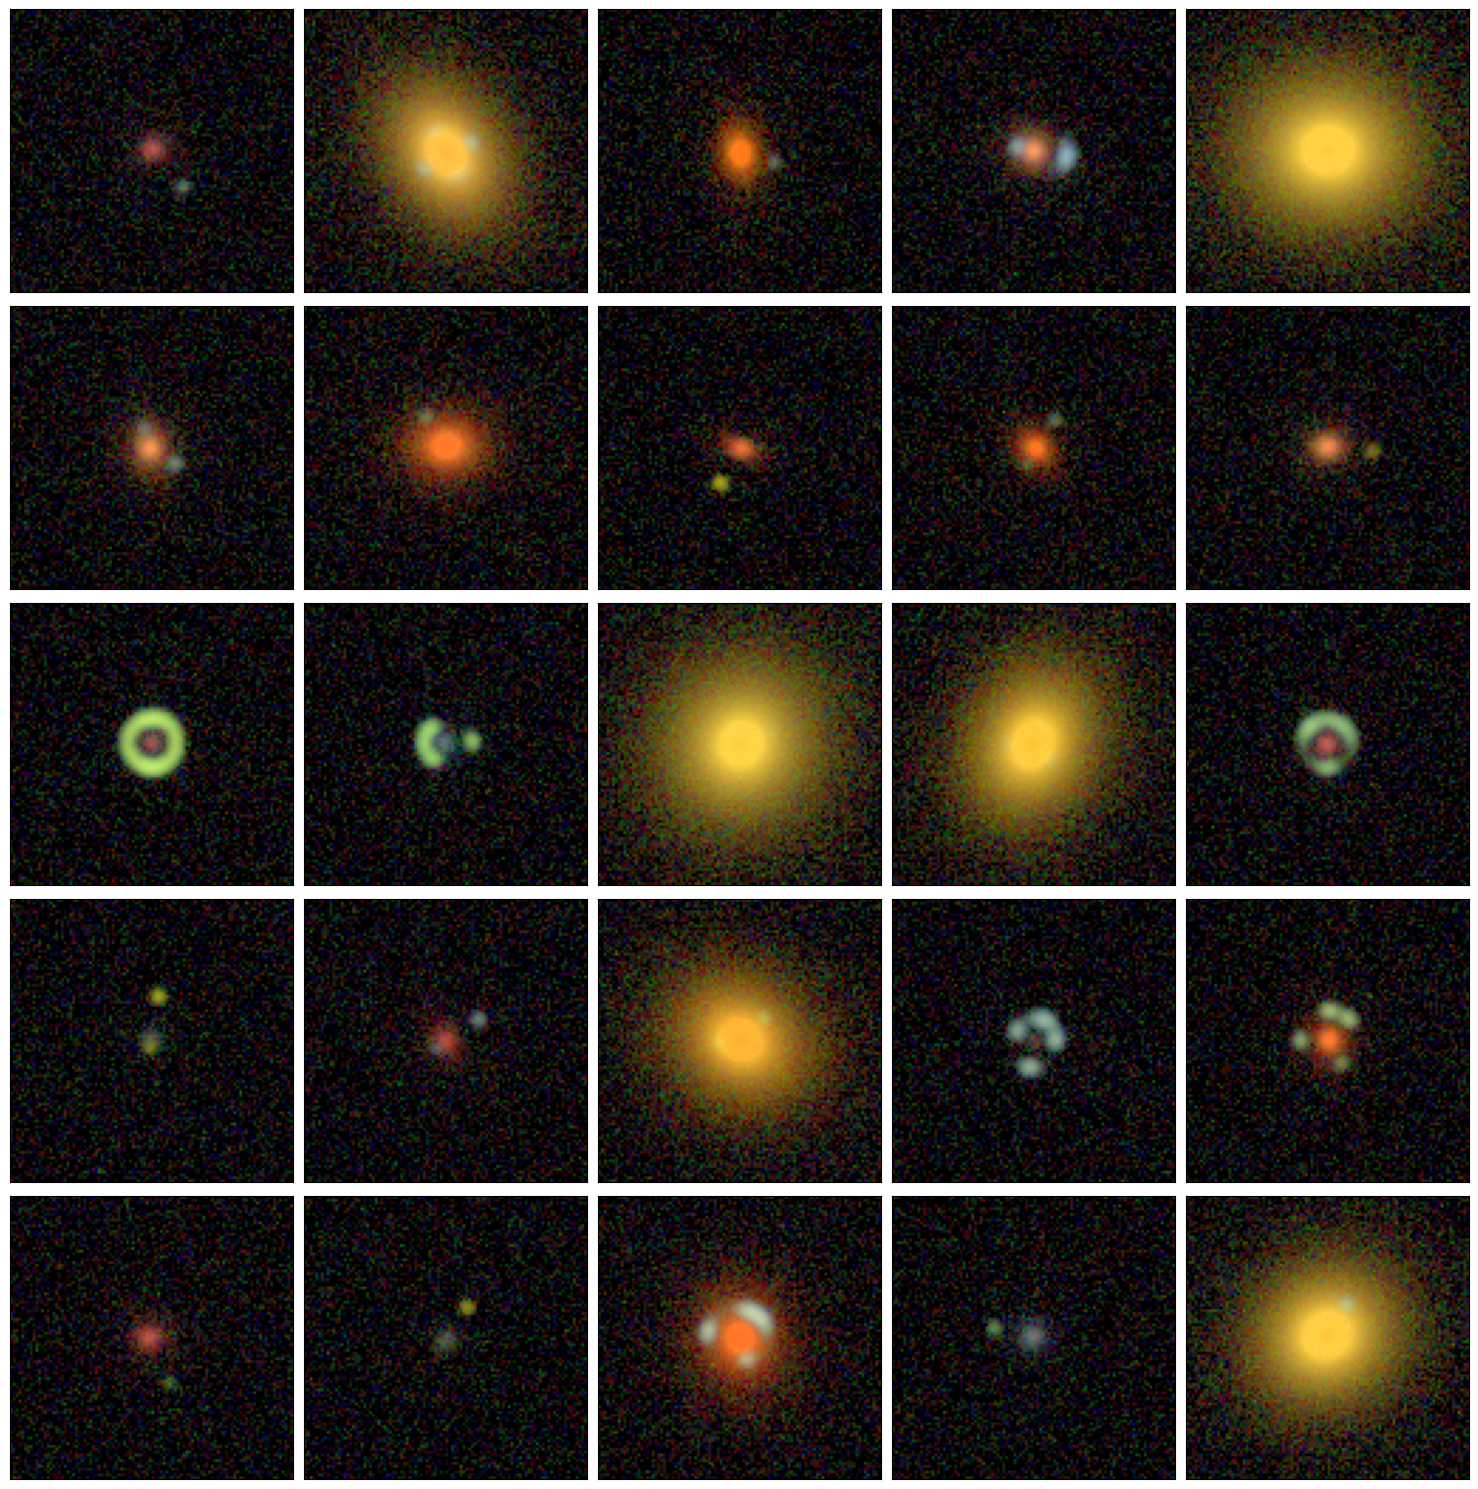

In [5]:
kwargs_lens_cut = {"min_image_separation": 3, "max_image_separation": 10}
gg_plot.plot_montage(rgb_band_list=["i", "r", "g"], 
                     n_horizont= 5,
                     n_vertical= 5,
                     kwargs_lens_cut=kwargs_lens_cut,
                    #  add_noise=False,
                     );

In [ ]:
# properties of the selected lenses
single_lens_params = {
    "lens_id": [],
    "z_D": [],
    "z_S": [],
    "theta_E": [],
    "sigma_v_D": [],
    "mag_S_i": [],
    "mag_S_r": [],
    "mag_S_g": [],
    "mag_S_z": [],
    "mag_S_y": [],
    "mag_D_i": [],
    "mag_D_r": [],
    "mag_D_g": [],
    "mag_D_z": [],
    "mag_D_y": [],
    "size_D": [],
    "e1_mass_D": [],
    "e2_mass_D": [],
    "e_mass_D": [],
    "gamma_pl": [],
    "R_e_kpc": [],
    "Sigma_half_Msun/pc2": [], # lensing mass surface density within 1/2 effective radius
    "surf_bri_mag/arcsec2": [],  # surface brightness within effective radius

}
id = 0
for lens in tqdm(selected_lenses, desc="Calculating lens properties"):
    # update the lens_id    
    single_lens_params["lens_id"].append(id)
    id += 1

    source = lens.source(index = 0)

    deflector = lens.deflector

    # get the deflector and source redshifts
    z_D = lens.deflector_redshift
    z_S = source.redshift

    # get the Einstein radii
    theta_E = lens.einstein_radius[0]

    # get the velocity dispersion
    sigma_v_D = deflector.velocity_dispersion()

    # get the source magnitudes
    mag_S_i = source.extended_source_magnitude("i")
    mag_S_r = source.extended_source_magnitude("r")
    mag_S_g = source.extended_source_magnitude("g")
    mag_S_z = source.extended_source_magnitude("z")
    mag_S_y = source.extended_source_magnitude("y")

    # get the deflector magnitudes
    mag_D_i = deflector.magnitude("i")
    mag_D_r = deflector.magnitude("r")
    mag_D_g = deflector.magnitude("g")
    mag_D_z = deflector.magnitude("z")
    mag_D_y = deflector.magnitude("y")

    # get the deflector sizes
    size_D = deflector.angular_size_light

    # ellipticities
    e1_mass_D, e2_mass_D = deflector.mass_ellipticity
    e_mass_D = np.sqrt(e1_mass_D**2 + e2_mass_D**2)

    gamma_pl = selected_lenses[0].deflector.halo_properties #TODO: check if this is correct

    # update single_lens_params dictionary
    single_lens_params["z_D"].append(z_D)
    single_lens_params["z_S"].append(z_S)
    single_lens_params["theta_E"].append(theta_E)
    single_lens_params["sigma_v_D"].append(sigma_v_D)
    single_lens_params["size_D"].append(size_D)
    single_lens_params["mag_S_i"].append(mag_S_i)
    single_lens_params["mag_S_r"].append(mag_S_r)
    single_lens_params["mag_S_g"].append(mag_S_g)
    single_lens_params["mag_S_z"].append(mag_S_z)
    single_lens_params["mag_S_y"].append(mag_S_y)
    single_lens_params["mag_D_i"].append(mag_D_i)
    single_lens_params["mag_D_r"].append(mag_D_r)
    single_lens_params["mag_D_g"].append(mag_D_g)
    single_lens_params["mag_D_z"].append(mag_D_z)
    single_lens_params["mag_D_y"].append(mag_D_y)
    single_lens_params["e1_mass_D"].append(e1_mass_D)
    single_lens_params["e2_mass_D"].append(e2_mass_D)
    single_lens_params["e_mass_D"].append(e_mass_D)
    single_lens_params["gamma_pl"].append(gamma_pl)

    #######################################
    # Calculate the surface density and surface brightness within the half-light radius
    #######################################
    half_light_radii = lens.deflector.angular_size_light # in arcsec

    lenstronomy_kwargs = lens.lenstronomy_kwargs()
    lens_model_lenstronomy = LensModel(
        lens_model_list=lenstronomy_kwargs[0]["lens_model_list"]
    )
    lenstronomy_kwargs_lens = lenstronomy_kwargs[1]["kwargs_lens"]

    deflector_center = lens.deflector.deflector_center

    grid = np.linspace(-half_light_radii, half_light_radii, 1000)
    xs, ys = np.meshgrid(grid + deflector_center[0], grid + deflector_center[1])
    kappa_map = lens_model_lenstronomy.kappa(xs, ys,
                                            kwargs = lenstronomy_kwargs_lens)
    kappa_within_half_light_radii = np.nanmean(kappa_map[np.sqrt(xs**2 + ys**2) < half_light_radii/2])

    D_s = cosmo_true.angular_diameter_distance(lens.source_redshift_list[0])  # Source distance
    D_d = cosmo_true.angular_diameter_distance(lens.deflector_redshift)  # Deflector distance
    D_ds = cosmo_true.angular_diameter_distance_z1z2(
        lens.deflector_redshift, lens.source_redshift_list[0]
    ) # Distance between deflector and source

    sigma_crit = (const.c**2 / (4 * np.pi * const.G )) * (D_s / (D_s * D_ds))
    sigma_crit = sigma_crit.to(u.Msun / u.pc**2).value
    surface_density_within_half_light_radii = sigma_crit * kappa_within_half_light_radii

    surface_brightness_map = deflector.surface_brightness(xs, ys, band = "g")
    mean_surface_brightness_within_eff_radius = np.nanmean(
        surface_brightness_map[np.sqrt(xs**2 + ys**2) < half_light_radii]
    )

    half_light_radii = cosmo_true.kpc_proper_per_arcmin(lens.deflector_redshift) * ((half_light_radii * u.arcsec).to(u.arcmin))
    half_light_radii = half_light_radii.to(u.kpc).value  # Convert to kpc

    # Update the single_lens_params dictionary with the surface density
    single_lens_params["R_e_kpc"].append(half_light_radii)
    single_lens_params["Sigma_half_Msun/pc2"].append(surface_density_within_half_light_radii)
    single_lens_params["surf_bri_mag/arcsec2"].append(mean_surface_brightness_within_eff_radius)
    

    ###################################
    ###################################

# convert the single_lens_params dictionary to a numpy array
single_lens_params = {
    key: np.array(value) for key, value in single_lens_params.items()
}

# astropy table
single_lens_params_table = Table(single_lens_params)

# save the table to a fits file
single_lens_params_table.write(
    f"../data/GGL_{sky_area_lens.value}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format="fits", overwrite=True
)

single_lens_params_table

python(7001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Calculating lens properties: 100%|██████████| 2782/2782 [04:06<00:00, 11.31it/s]


<Table length=2782>
lens_id         z_D         ... Sigma_half_Msun/pc2 surf_bri_mag/arcsec2
 int64        float64       ...       float64             float64       
------- ------------------- ... ------------------- --------------------
      0   1.874766281062172 ...   6542.855098668025   28.158590719935617
      1  0.4138050696952206 ...  3383.0904062076133   23.684399870902915
      2 0.32325614833622546 ...  2424.2058253119626   22.612022305783967
      3   0.562141659276947 ...   3088.000865920878   23.161506725191224
      4 0.32961696763102005 ...  3160.3052913670053   22.013002413861788
      5  1.1885315447926554 ...   7201.423349682187    23.82337151452748
      6  1.2440370141998318 ...   5888.682565311953   26.213378895096472
      7  1.2186608418866445 ...  6574.3099157719225   27.312897074985525
      8  1.3205838348704433 ...   5373.308523883364    25.15147809628904
    ...                 ... ...                 ...                  ...
   2772  0.4325734322992549 ...   3899.234688002168   23.459599796188215
   2773  1.9704075826868674 ...   9664.468279877527    27.89272922995293
   2774  0.4927098773228751 ...  3226.8716782294014    22.81878278597964
   2775  0.6303823988850212 ...  4344.0337226877555   23.554196182210113
   2776 0.11685474506830067 ...  1611.2020030705364   20.208738985362718
   2777 0.38643665627536683 ...   3861.559317959449   22.647005090196213
   2778  1.4006223814713854 ...   6449.370817800014   26.299556202652006
   2779  2.2158662567903806 ...   7775.245998616736   28.696510879168176
   2780  1.1135358168006713 ...   4847.036671885054    25.04281787191887
   2781  1.3444376462309926 ...   5471.687376364484   26.744734632652992

In [114]:
print(f"Number of lenses in the table: {len(single_lens_params_table)}")

Number of lenses in the table: 2922


In [ ]:
# single_lens_params_table.write(
#     f"GGL_{sky_area_lens.value}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE_all_sky_areas_same.fits", format="fits", overwrite=True
# )

## Make SLSim Fundamental Plane

In [75]:
# slsim traditional fundamental plane

coeffs_slsim = fit_plane(
    x = np.log10(single_lens_params_table["R_e_kpc"]),
    y = single_lens_params_table["surf_bri_half_mag/arcsec2"],
    z = np.log10(single_lens_params_table["sigma_v_D"])
)

scatter_slsim_sigma_v = find_scatter(
    x = np.log10(single_lens_params_table["R_e_kpc"]),
    y = single_lens_params_table["surf_bri_half_mag/arcsec2"],
    z = np.log10(single_lens_params_table["sigma_v_D"]),
    coeffs=coeffs_slsim
)

display(Markdown(f"SLSim FP: "+"$\\log_{10}(\\sigma_v)$ = " + f"{coeffs_slsim[0]:.2f} * "+"$\\log_{10}(R_e)$"+f" + {coeffs_slsim[1]:.2f} * "+"$\\mu_e + "+f"{coeffs_slsim[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(\\sigma_v)$ = " + f"{np.std(scatter_slsim_sigma_v):.2f} dex "+"$\\Rightarrow {\\Delta \\sigma_v}/{\\sigma_v}$: " + f"{np.std(scatter_slsim_sigma_v)*np.log(10)*100:.2f} %"))

SLSim FP: $\log_{10}(\sigma_v)$ = 0.34 * $\log_{10}(R_e)$ + 0.01 * $\mu_e + 1.94$ $\Rightarrow \Delta \log_{10}(\sigma_v)$ = 0.06 dex $\Rightarrow {\Delta \sigma_v}/{\sigma_v}$: 13.47 %

In [76]:
# slsim mass fundamental plane

coeffs_slsim = fit_plane(
    x = np.log10(single_lens_params_table["R_e_kpc"]),
    y = np.log10(single_lens_params_table["Sigma_half_Msun/pc2"]),
    z = np.log10(single_lens_params_table["sigma_v_D"])
)

scatter_slsim_sigma_v = find_scatter(
    x = np.log10(single_lens_params_table["R_e_kpc"]),
    y = np.log10(single_lens_params_table["Sigma_half_Msun/pc2"]),
    z = np.log10(single_lens_params_table["sigma_v_D"]),
    coeffs=coeffs_slsim
)

display(Markdown(f"SLSim MFP: "+"$\\log_{10}(\\sigma_v)$ = " + f"{coeffs_slsim[0]:.2f} * "+"$\\log_{10}(R_e)$"+f" + {coeffs_slsim[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_slsim[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(\\sigma_v)$ = " + f"{np.std(scatter_slsim_sigma_v):.2f} dex "+"$\\Rightarrow {\\Delta \\sigma_v}/{\\sigma_v}$: " + f"{np.std(scatter_slsim_sigma_v)*np.log(10)*100:.2f} %"))

SLSim MFP: $\log_{10}(\sigma_v)$ = 0.34 * $\log_{10}(R_e)$ + 0.24 * $\log_{10}(\Sigma_{1/2}) + 1.29$ $\Rightarrow \Delta \log_{10}(\sigma_v)$ = 0.04 dex $\Rightarrow {\Delta \sigma_v}/{\sigma_v}$: 8.89 %

SLSim fundamental plane: $\log_{10}(\sigma_v)$ = 0.34 * $\log_{10}(R_e)$ + 0.24 * $\log_{10}(\Sigma_{1/2}) + 1.29$ $\Rightarrow \Delta \log_{10}(\sigma_v)$ = 0.039 dex $\Rightarrow {\Delta \sigma_v}/{\sigma_v}$: 8.89 %

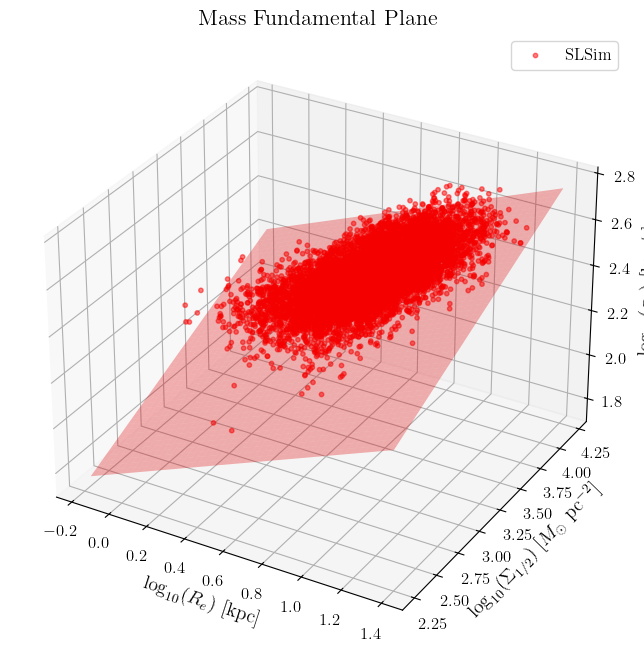

In [77]:
## plot the fundamental plane in 3D

# %matplotlib widget

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': '3d'})

# SLSim fundamental plane
ax.scatter(
    np.log10(single_lens_params_table["R_e_kpc"]),
    np.log10(single_lens_params_table["Sigma_half_Msun/pc2"]),
    np.log10(single_lens_params_table["sigma_v_D"]),
    c='red', s=10, alpha=0.5, label='SLSim'
)
x_plane = np.linspace(np.nanmin(np.log10(single_lens_params_table["R_e_kpc"])),
                      np.nanmax(np.log10(single_lens_params_table["R_e_kpc"])), 100)
y_plane = np.linspace(np.nanmin(np.log10(single_lens_params_table["Sigma_half_Msun/pc2"])),
                      np.nanmax(np.log10(single_lens_params_table["Sigma_half_Msun/pc2"])), 100)
X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
Z_plane = coeffs_slsim[0] * X_plane + coeffs_slsim[1] * Y_plane + coeffs_slsim[2]
ax.plot_surface(X_plane, Y_plane, Z_plane, color='red', alpha=0.3)

# Set labels and title
ax.set_xlabel(r'$\log_{10}(R_{e})$ [kpc]')
ax.set_ylabel(r'$\log_{10}(\Sigma_{1/2})$ [$M_\odot$ pc$^{-2}$]')
ax.set_zlabel(r'$\log_{10}(\sigma_v)$ [km/s]')
ax.set_title('Mass Fundamental Plane', fontsize=16)

ax.legend()

display(Markdown(f"SLSim fundamental plane: "+"$\\log_{10}(\\sigma_v)$ = " + f"{coeffs_slsim[0]:.2f} * "+"$\\log_{10}(R_e)$"+f" + {coeffs_slsim[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_slsim[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(\\sigma_v)$ = " + f"{np.std(scatter_slsim_sigma_v):.3f} dex "+"$\\Rightarrow {\\Delta \\sigma_v}/{\\sigma_v}$: " + f"{np.std(scatter_slsim_sigma_v)*np.log(10)*100:.2f} %"))

In [78]:
# slsim fundamental plane with R_e on the z-axis

coeffs_slsim_alt = fit_plane(
    z = np.log10(single_lens_params_table["R_e_kpc"]),
    y = np.log10(single_lens_params_table["Sigma_half_Msun/pc2"]),
    x = np.log10(single_lens_params_table["sigma_v_D"])
)

scatter_slsim_R_e = find_scatter(
    z = np.log10(single_lens_params_table["R_e_kpc"]),
    y = np.log10(single_lens_params_table["Sigma_half_Msun/pc2"]),
    x = np.log10(single_lens_params_table["sigma_v_D"]),
    coeffs=coeffs_slsim_alt
)

display(Markdown(f"SLSim fundamental plane: "+"$\\log_{10}(R_e)$ = " + f"{coeffs_slsim_alt[0]:.2f} * "+"$\\log_{10}(\\sigma_v)$"+f" + {coeffs_slsim_alt[1]:.2f} * "+"$\\log_{10}(\\Sigma_{1/2}) + "+f"{coeffs_slsim_alt[2]:.2f}$ " + "$\\Rightarrow \\Delta \\log_{10}(R_e)$ = " + f"{np.std(scatter_slsim_R_e):.2f} dex "+"$\\Rightarrow {\\Delta R_e}/{R_e}$: " + f"{np.std(scatter_slsim_R_e)*np.log(10)*100:.2f} %"))

SLSim fundamental plane: $\log_{10}(R_e)$ = 2.26 * $\log_{10}(\sigma_v)$ + -0.47 * $\log_{10}(\Sigma_{1/2}) + -2.99$ $\Rightarrow \Delta \log_{10}(R_e)$ = 0.10 dex $\Rightarrow {\Delta R_e}/{R_e}$: 22.95 %

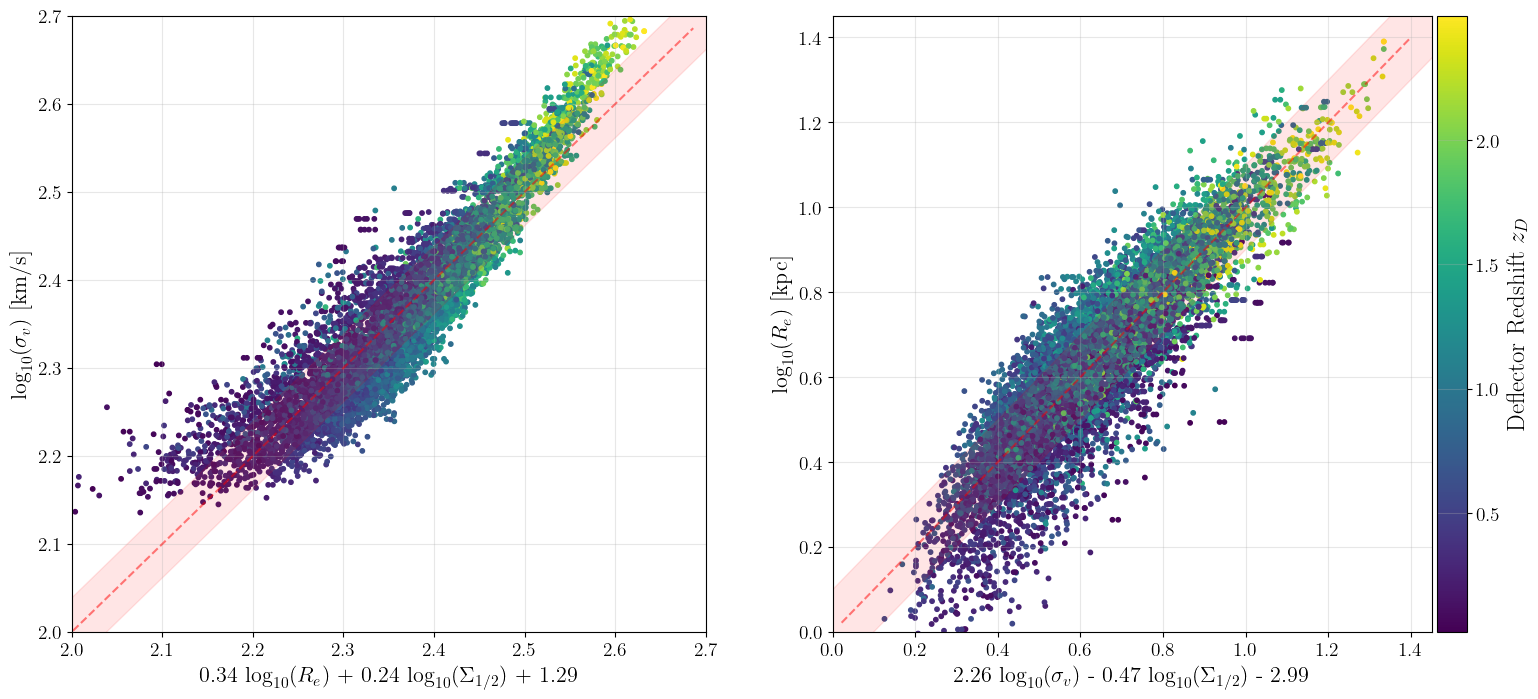

In [92]:
# side-by-side plot of the two fundamental planes
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# sigma_v fundamental plane
axs[0].scatter(
    coeffs_slsim[0] * np.log10(single_lens_params_table["R_e_kpc"]) + 
    coeffs_slsim[1] * np.log10(single_lens_params_table["Sigma_half_Msun/pc2"]) + 
    coeffs_slsim[2],
    np.log10(single_lens_params_table["sigma_v_D"]),
    c=single_lens_params_table["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
axs[0].set_xlabel(f'{coeffs_slsim[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_slsim[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_slsim[2]:.2f}')
axs[0].set_ylabel(r'$\log_{10}(\sigma_v)$ [km/s]')
# axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

# Plot the fitted plane with a faded scatter
# y = x
axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
            [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
            color='red', linestyle='--', alpha=0.5, label='y = x')
# faded region for the scatter
x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
y_faded = x_faded
axs[0].fill_between(x_faded, y_faded - np.std(scatter_slsim_sigma_v),
                    y_faded + np.std(scatter_slsim_sigma_v), color='red', alpha=0.1)

# R_e fundamental plane
scatter_plot = axs[1].scatter(
    coeffs_slsim_alt[0] * np.log10(single_lens_params_table["sigma_v_D"]) + 
    coeffs_slsim_alt[1] * np.log10(single_lens_params_table["Sigma_half_Msun/pc2"]) + 
    coeffs_slsim_alt[2],
    np.log10(single_lens_params_table["R_e_kpc"]),
    c=single_lens_params_table["z_D"], s=10, label='SLSim MFP', 
    cmap='viridis'
)
axs[1].set_xlabel(f'{coeffs_slsim_alt[0]:.2f} ' + r'$\log_{10}(\sigma_v)$ ' + f'{'+' if coeffs_slsim_alt[1] > 0 else '-'} {np.abs(coeffs_slsim_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_slsim_alt[2] > 0 else '-'} {np.abs(coeffs_slsim_alt[2]):.2f}')
axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
# axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
# Plot the fitted plane with a faded scatter
# y = x
axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
            [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
            color='red', linestyle='--', alpha=0.5, label='y = x')
# faded region for the scatter
x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
y_faded = x_faded
axs[1].fill_between(x_faded, y_faded - np.std(scatter_slsim_R_e),
                    y_faded + np.std(scatter_slsim_R_e), color='red', alpha=0.1)

# common colorbar
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(scatter_plot, cax=cax)
cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


# increase the font size of the labels and title
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=18)
    # ax.legend(fontsize=14)

cbar.ax.tick_params(labelsize=14)  # Colorbar tick labels

# cbar label size
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=18)

axs[0].set_xlim(2, 2.7)
axs[0].set_ylim(2, 2.7)
axs[1].set_xlim(0, 1.45)
axs[1].set_ylim(0, 1.45)

# save the figure
fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

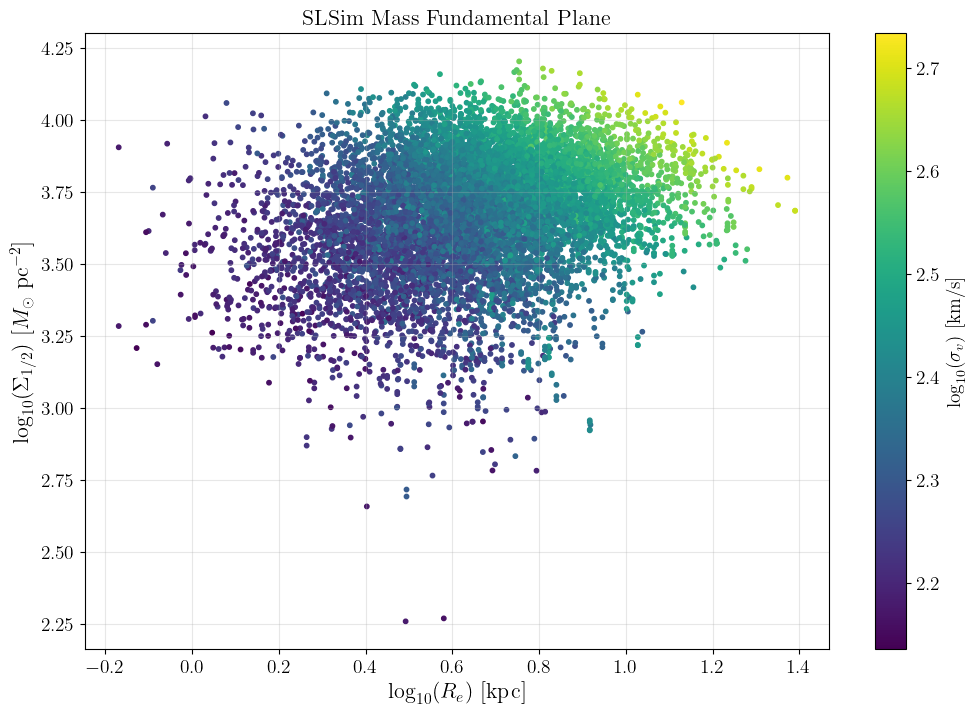

In [48]:
# scatter plot of log10(R_e) vs log10(Sigma_e) with color by log10(sigma_v)
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    np.log10(single_lens_params_table["R_e_kpc"]),
    np.log10(single_lens_params_table["Sigma_half_Msun/pc2"]),
    c=np.log10(single_lens_params_table["sigma_v_D"]), s=10, label='SLSim MFP', 
    cmap='viridis'
)
cbar = plt.colorbar(scatter, ax=ax, label=r'$\log_{10}(\sigma_v)$ [km/s]')
ax.set_xlabel(r'$\log_{10}(R_e)$ [kpc]', fontsize=16)
ax.set_ylabel(r'$\log_{10}(\Sigma_{1/2})$ [$M_\odot$ pc$^{-2}$]', fontsize=16)
ax.set_title('SLSim Mass Fundamental Plane', fontsize=16)   

# make labels larger
ax.tick_params(axis='both', which='major', labelsize=14)
cbar.ax.tick_params(labelsize=14)  # Colorbar tick labels

## Finding Near Identical Deflectors On the Fundamental Plane

In [55]:
# MAKING BINS ON THE FUNDAMENTAL PLANE AND CALCULATING MEAN AND STD OF NOISE METRIC AND VELOCITY DISPERSION
num_bins = 20
THRESHOLD_ABS_DELTA_Z = 0.01

x_label = r'$\log_{10}$($R_{1/2}$ [kpc])'
z_label = r'$\log_{10}$($\sigma_v$ [km/s])'
y_label = r'$\log_{10}$($\Sigma_{1/2}$ [$M_\odot$ pc$^{-2}$])'

# Extract data from table
x = np.log10(single_lens_params_table["R_e_kpc"])
y = np.log10(single_lens_params_table["Sigma_half_Msun/pc2"])
z = np.log10(single_lens_params_table["sigma_v_D"])

# Create bins
half_light_radius_bins = np.linspace(np.nanmin(x), np.nanmax(x), num_bins)
surface_density_bins = np.linspace(np.nanmin(y), np.nanmax(y), num_bins)

# Binned statistics
number_of_usable_pairs_bins = np.zeros((num_bins, num_bins))  # number of usable pairs in each bin

scatter_delta_sigma_v_true_bins = np.zeros((num_bins, num_bins)) # std(sigma_v_D1 - sigma_v_D2) for each bin
scatter_delta_z_bins = np.zeros((num_bins, num_bins)) # std(z_D1 - z_D2) for each bin
mean_sigma_v_true_bins = np.zeros((num_bins, num_bins)) # mean(sigma_v_D1, sigma_v_D2) for each bin
scatter_rel_sigma_v_true_bins = np.zeros((num_bins, num_bins)) # std((sigma_v_D1 - sigma_v_D2))/(mean(sigma_v_D1, sigma_v_D2)) for each bin

scatter_delta_beta_E_bins = np.zeros((num_bins, num_bins)) # std(beta_E_pseudo - beta_E_DSPL) for each bin
scatter_rel_beta_E_bins = np.zeros((num_bins, num_bins)) # std((beta_E_pseudo - beta_E_DSPL)/beta_E_pseudo) for each bin

# Bins stats from all galaxies in bin
all_galaxies_std_sigma_v_bins = np.zeros((num_bins, num_bins)) # std(sigma_v_D) for each bin
all_galaxies_mean_sigma_v_bins = np.zeros((num_bins, num_bins))
all_galaxies_rel_std_sigma_v_bins = np.zeros((num_bins, num_bins)) # std(sigma_v_D)/mean(sigma_v_D) for each bin
all_galaxies_std_z_bins = np.zeros((num_bins, num_bins)) # std(z_D) for each bin
all_galaxies_mean_z_bins = np.zeros((num_bins, num_bins)) # mean(z_D) for each bin
all_galaxies_rel_std_z_bins = np.zeros((num_bins, num_bins)) # std(z_D)/mean(z_D) for each bin

# theta_E1_by_theta_E2_MFP - theta_E1_by_theta_E2 relative scatter for each bin
all_lenses_rel_scatter_theta_E1_by_theta_E2_MFP_bins = np.zeros((num_bins, num_bins)) # std(theta_E1_by_theta_E2_from_MFP - theta_E1_by_theta_E2)/mean(theta_E1_by_theta_E2) for each bin

# Individual pair data
individual_pair_data = {
    'theta_E1_by_theta_E2': [],
    'theta_E1_by_theta_E2_virt': [],
    'theta_E1_virt_by_theta_E2': [],
    'noise_metrics': [],
    'z_D1': [],
    'z_D2': [],
    'z_S1': [],
    'z_S2': [],
    'sigma_v_D1': [],
    'sigma_v_D2': [],
    'lens1_id': [],
    'lens2_id': [],
}


def process_pair(lens1, lens2, lens1_id, lens2_id):
    """process a pair of lenses."""
    d1, d2 = lens1.deflector, lens2.deflector
    s1, s2 = lens1.source(index=0), lens2.source(index=0)
    
    # Real Einstein radii
    theta_E_D1_S1 = lens1.einstein_radius[0]
    theta_E_D2_S2 = lens2.einstein_radius[0]
    
    # Virtual lenses for cross combinations
    virt_lens1 = Lens(source_class=s2, deflector_class=d1, cosmo=cosmo_true, los_class=lens1.los_class)
    virt_lens2 = Lens(source_class=s1, deflector_class=d2, cosmo=cosmo_true, los_class=lens2.los_class)

    # Virtual Einstein radii
    theta_E_D1_S2 = virt_lens1.einstein_radius[0]
    theta_E_D2_S1 = virt_lens2.einstein_radius[0]
    
    # Calculate noise metric
    noise_metric = np.sqrt(
        (theta_E_D1_S1/theta_E_D2_S2 - theta_E_D1_S1/theta_E_D1_S2)**2 + 
        (theta_E_D1_S1/theta_E_D2_S2 - theta_E_D2_S1/theta_E_D2_S2)**2
    )

    ## Store individual pair data
    individual_pair_data['theta_E1_by_theta_E2'].append(theta_E_D1_S1/theta_E_D2_S2)
    individual_pair_data['theta_E1_by_theta_E2_virt'].append(theta_E_D1_S1/theta_E_D1_S2)
    individual_pair_data['theta_E1_virt_by_theta_E2'].append(theta_E_D2_S1/theta_E_D2_S2)
    individual_pair_data['noise_metrics'].append(noise_metric)
    individual_pair_data['z_D1'].append(d1.redshift)
    individual_pair_data['z_D2'].append(d2.redshift)
    individual_pair_data['sigma_v_D1'].append(d1.velocity_dispersion())
    individual_pair_data['sigma_v_D2'].append(d2.velocity_dispersion())
    individual_pair_data['lens1_id'].append(lens1_id)
    individual_pair_data['lens2_id'].append(lens2_id)
    individual_pair_data['z_S1'].append(s1.redshift)
    individual_pair_data['z_S2'].append(s2.redshift)

    diff_sigma_v_D = d1.velocity_dispersion() - d2.velocity_dispersion()
    diff_z_D = d1.redshift - d2.redshift
    mean_sigma_v_D = (d1.velocity_dispersion() + d2.velocity_dispersion()) / 2
    mean_z_D = (d1.redshift + d2.redshift) / 2


    beta_E_pseudo = theta_E_D1_S1/theta_E_D2_S2
    beta_E_DSPL_D1 = theta_E_D1_S1/theta_E_D1_S2
    beta_E_DSPL_D2 = theta_E_D2_S1/theta_E_D2_S2

    return noise_metric, mean_sigma_v_D, diff_sigma_v_D, beta_E_pseudo, beta_E_DSPL_D1, beta_E_DSPL_D2, diff_z_D, mean_z_D

def process_bin(i, j):
    """Process a single bin and return statistics."""
    # Find indices of lenses within the bin
    indices = np.where(
        (x >= half_light_radius_bins[i]) &
        (x < half_light_radius_bins[i + 1]) &
        (y >= surface_density_bins[j]) &
        (y < surface_density_bins[j + 1])
    )[0]
    
    if len(indices) <= 1:
        return (
            np.nan,  # scatter_delta_sigma_v_true
            np.nan,  # noise_metrics_mean
            np.nan,  # scatter_delta_z_true
            np.nan,  # mean_sigma_v_true
            np.nan,  # scatter_rel_sigma_v_true
            np.nan,  # scatter_delta_beta_E
            np.nan,  # scatter_rel_beta_E
            np.nan,  # all_galaxies_std_sigma_v
            np.nan,  # all_galaxies_mean_sigma_v
            np.nan,  # all_galaxies_rel_std_sigma_v
            np.nan,  # all_galaxies_std_z
            np.nan,  # all_galaxies_mean_z
            np.nan,   # all_galaxies_rel_std_z
            0  # num_usable_pairs
        )
    
    # Get lens objects in the bin
    lens_ids_in_bin = single_lens_params_table["lens_id"][indices]
    lenses_in_bin = [selected_lenses[lens_id] for lens_id in lens_ids_in_bin]
    
    # Process pairs of lenses in the bin
    pairs = list(combinations(lenses_in_bin, 2))
    pairs_ids = list(combinations(lens_ids_in_bin, 2))
    
    noise_metrics = []
    mean_sigma_v_Ds = []
    diff_sigma_v_Ds = []
    diff_z_Ds = []
    mean_z_Ds = []
    beta_E_pseudos = []
    beta_E_DSPL_D1s = []
    beta_E_DSPL_D2s = []
    num_usable_pairs = 0
    for (lens1, lens2), (lens1_id, lens2_id) in zip(pairs, pairs_ids):
        noise_metric, mean_sigma_v_D, diff_sigma_v_D, beta_E_pseudo, beta_E_DSPL_D1, beta_E_DSPL_D2, diff_z_D, mean_z_D = process_pair(lens1, lens2, lens1_id, lens2_id)
        if np.abs(diff_z_D) < THRESHOLD_ABS_DELTA_Z:
            noise_metrics.append(noise_metric)
            mean_sigma_v_Ds.append(mean_sigma_v_D)
            diff_sigma_v_Ds.append(diff_sigma_v_D)
            diff_z_Ds.append(diff_z_D)
            mean_z_Ds.append(mean_z_D)
            beta_E_pseudos.append(beta_E_pseudo)
            beta_E_DSPL_D1s.append(beta_E_DSPL_D1)
            beta_E_DSPL_D2s.append(beta_E_DSPL_D2)
            num_usable_pairs += 1

    # numpy arrays
    noise_metrics = np.array(noise_metrics)
    mean_sigma_v_Ds = np.array(mean_sigma_v_Ds)
    diff_sigma_v_Ds = np.array(diff_sigma_v_Ds)
    mean_z_Ds = np.array(mean_z_Ds)
    diff_z_Ds = np.array(diff_z_Ds)
    beta_E_pseudos = np.array(beta_E_pseudos)
    beta_E_DSPL_D1s = np.array(beta_E_DSPL_D1s)
    beta_E_DSPL_D2s = np.array(beta_E_DSPL_D2s)
    beta_E_DSPLs = (beta_E_DSPL_D1s + beta_E_DSPL_D2s) / 2


    # Calculate statistics for a bin from pairs
    scatter_delta_sigma_v_true = np.std(diff_sigma_v_Ds) if len(diff_sigma_v_Ds) > 0 else np.nan
    scatter_delta_z_true = np.std(diff_z_Ds) if len(diff_z_Ds) > 0 else np.nan
    mean_sigma_v_true = np.mean(mean_sigma_v_Ds) if len(mean_sigma_v_Ds) > 0 else np.nan
    scatter_rel_sigma_v_true = scatter_delta_sigma_v_true / mean_sigma_v_true if mean_sigma_v_true != 0 else np.nan

    scatter_delta_beta_E = np.std(beta_E_pseudos - beta_E_DSPLs) if len(beta_E_pseudos) > 0 else np.nan
    scatter_rel_beta_E = np.std((beta_E_pseudos - beta_E_DSPLs) / beta_E_pseudos) if len(beta_E_pseudos) > 0 else np.nan

    # Calculate statistics for a bin from all galaxies in the bin
    all_galaxies_mean_sigma_v = np.mean([lens.deflector.velocity_dispersion() for lens in lenses_in_bin])
    all_galaxies_std_sigma_v = np.std([lens.deflector.velocity_dispersion() for lens in lenses_in_bin])
    all_galaxies_rel_std_sigma_v = all_galaxies_std_sigma_v / all_galaxies_mean_sigma_v if all_galaxies_mean_sigma_v != 0 else np.nan
    all_galaxies_mean_z = np.mean([lens.deflector.redshift for lens in lenses_in_bin])
    all_galaxies_std_z = np.std([lens.deflector.redshift for lens in lenses_in_bin])
    all_galaxies_rel_std_z = all_galaxies_std_z / all_galaxies_mean_z if all_galaxies_mean_z != 0 else np.nan


    return (
        scatter_delta_sigma_v_true, 
        np.mean(noise_metrics),  # Mean noise metric for the bin
        scatter_delta_z_true, 
        mean_sigma_v_true, 
        scatter_rel_sigma_v_true, 
        scatter_delta_beta_E, 
        scatter_rel_beta_E,
        all_galaxies_std_sigma_v,
        all_galaxies_mean_sigma_v,
        all_galaxies_rel_std_sigma_v,
        all_galaxies_std_z,
        all_galaxies_mean_z,
        all_galaxies_rel_std_z,
        num_usable_pairs
    )
    


# Main calculation loop
for i in tqdm(range(num_bins - 1), desc="Calculating bin statistics"):
    for j in range(num_bins - 1):
        rslt = process_bin(i, j)
        scatter_delta_sigma_v_true_bins[i, j] = rslt[0]
        # noise_metrics_mean_bins[i, j] = rslt[1]
        scatter_delta_z_bins[i, j] = rslt[2]
        mean_sigma_v_true_bins[i, j] = rslt[3]
        scatter_rel_sigma_v_true_bins[i, j] = rslt[4]
        scatter_delta_beta_E_bins[i, j] = rslt[5]
        scatter_rel_beta_E_bins[i, j] = rslt[6]
        all_galaxies_std_sigma_v_bins[i, j] = rslt[7]
        all_galaxies_mean_sigma_v_bins[i, j] = rslt[8]
        all_galaxies_rel_std_sigma_v_bins[i, j] = rslt[9]
        all_galaxies_std_z_bins[i, j] = rslt[10]
        all_galaxies_mean_z_bins[i, j] = rslt[11]
        all_galaxies_rel_std_z_bins[i, j] = rslt[12]
        number_of_usable_pairs_bins[i, j] = rslt[13]

# Convert individual pair data to numpy arrays
for key in individual_pair_data:
    individual_pair_data[key] = np.array(individual_pair_data[key])

# Create a table with individual pair data
individual_pair_data_table = Table(individual_pair_data)

Calculating bin statistics:   0%|          | 0/19 [00:00<?, ?it/s]/Users/paras/Library/CloudStorage/GoogleDrive-paras.sharma@stonybrook.edu/My Drive/SBU Courses/Spring 2025/PHY688 - Lensing/strong-lensing-spring-2025/lenstronomy/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_83880/3323120352.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  (theta_E_D1_S1/theta_E_D2_S2 - theta_E_D1_S1/theta_E_D1_S2)**2 +
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000

## How Scatter in $\sigma_v$ Propagates to $\beta_E$

Correlation Coefficient: 1.00, Slope: 2.04, Intercept: 0.00, Standard Error: 0.01

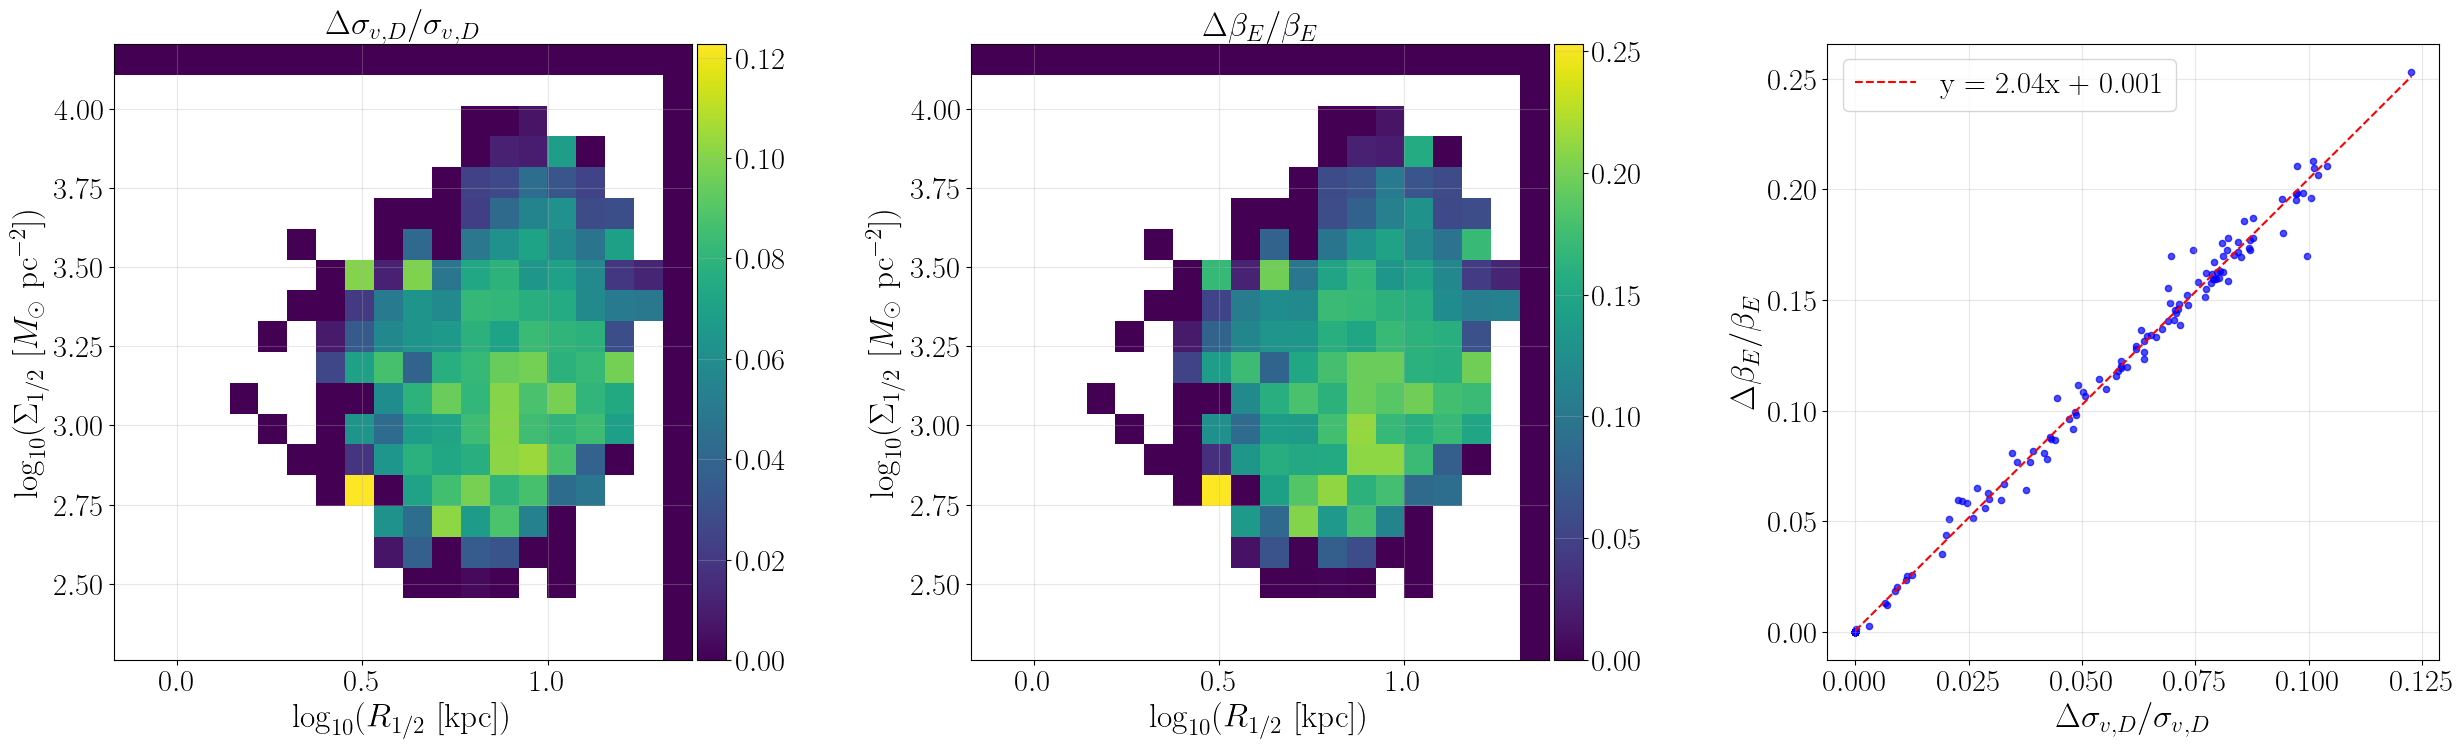

In [56]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 3, figsize=(30, 8))

base_fontsize = 22

# First plot: scatter_rel_sigma_v_true_bins
im1 = axs[0].imshow(scatter_rel_sigma_v_true_bins, origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(half_light_radius_bins), np.nanmax(half_light_radius_bins),
    np.nanmin(surface_density_bins), np.nanmax(surface_density_bins)
  ])
axs[0].set_xlabel(x_label)
axs[0].set_ylabel(y_label)
axs[0].set_title(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=base_fontsize+2)

# Second plot: scatter_rel_beta_E_bins
im2 = axs[1].imshow(scatter_rel_beta_E_bins, origin='lower', aspect='auto', cmap='viridis',
  extent=[
    np.nanmin(half_light_radius_bins), np.nanmax(half_light_radius_bins),
    np.nanmin(surface_density_bins), np.nanmax(surface_density_bins)
  ])
axs[1].set_xlabel(x_label)
axs[1].set_ylabel(y_label)
axs[1].set_title(r'${\Delta \beta_E}/{\beta_E}$', fontsize=base_fontsize+2)

# Third plot: scatter plot between the two quantities
axs[2].scatter(scatter_rel_sigma_v_true_bins.flatten(),
    scatter_rel_beta_E_bins.flatten(),
    s=20, alpha=0.7, c='blue')
axs[2].set_xlabel(r'${\Delta \sigma_{v,D}}/{\sigma_{v,D}}$', fontsize=20)
axs[2].set_ylabel(r'${\Delta \beta_E}/{\beta_E}$', fontsize=20)

# Fit and plot line for the scatter plot
x_scatter = scatter_rel_sigma_v_true_bins.flatten()
y_scatter = scatter_rel_beta_E_bins.flatten()
mask = ~np.isnan(x_scatter) & ~np.isnan(y_scatter)
x_scatter = x_scatter[mask]
y_scatter = y_scatter[mask]
coeffs = np.polyfit(x_scatter, y_scatter, 1)
x_fit = np.linspace(np.nanmin(x_scatter), np.nanmax(x_scatter), 100)
y_fit = coeffs[0] * x_fit + coeffs[1]
axs[2].plot(x_fit, y_fit, color='red', linestyle='--', 
  label=f'y = {coeffs[0]:.2f}x + {coeffs[1]:.3f}')
axs[2].legend(fontsize=base_fontsize)

# Create separate axes for colorbars that take up the extra space

# Create colorbars with larger size to take up extra space
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(im1, cax=cax1)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax=cax2)

# Apply consistent styling
for ax in axs:
  ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
  ax.set_xlabel(ax.get_xlabel(), fontsize=base_fontsize+2)
  ax.set_ylabel(ax.get_ylabel(), fontsize=base_fontsize+2)
  ax.set_title(ax.get_title(), fontsize=base_fontsize+2)

# Style colorbars
cbar1.ax.tick_params(labelsize=base_fontsize)
cbar2.ax.tick_params(labelsize=base_fontsize)

# Adjust the subplot widths to make them similar
plt.subplots_adjust(wspace=0.4)

# Save the figure
fig.savefig(f"../figures/slsim_scatter_rel_sigma_v_beta_E.pdf", bbox_inches='tight', dpi=300)

# Correlation Coefficient and Scatter in Linear Regression
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    x_scatter, y_scatter
)
display(Markdown(f"Correlation Coefficient: {r_value:.2f}, Slope: {slope:.2f}, Intercept: {intercept:.2f}, Standard Error: {std_err:.2f}"))


Total number of usable pairs: 20088.0


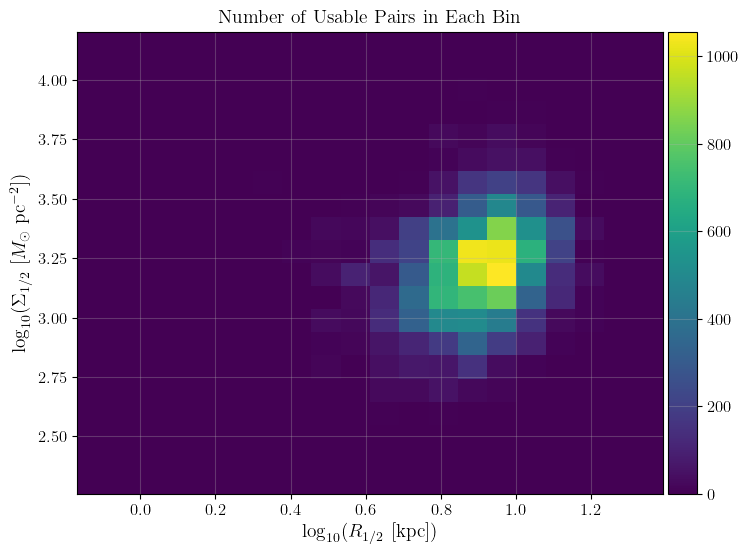

In [57]:
# usable pairs in each bin
fig, ax = plt.subplots()
im = ax.imshow(number_of_usable_pairs_bins, origin='lower', aspect='auto',
               cmap='viridis',
               extent=[
                   np.nanmin(half_light_radius_bins), np.nanmax(half_light_radius_bins),
                   np.nanmin(surface_density_bins), np.nanmax(surface_density_bins)
               ])
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title('Number of Usable Pairs in Each Bin')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

print(f"Total number of usable pairs: {np.sum(number_of_usable_pairs_bins)}")

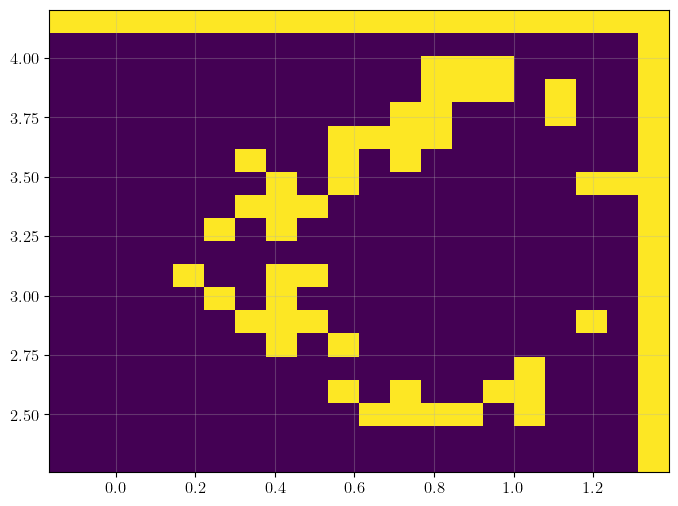

In [58]:
# mask small relative scatter in sigma_v
mask_small_scatter = scatter_rel_sigma_v_true_bins < 0.025
plt.imshow(mask_small_scatter, origin='lower', aspect='auto',
           cmap='viridis',
           extent=[
               np.nanmin(half_light_radius_bins), np.nanmax(half_light_radius_bins),
               np.nanmin(surface_density_bins), np.nanmax(surface_density_bins)
           ])

In [61]:
individual_pair_data_table[
    np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) < 0.01
]

<Table length=20088>
theta_E1_by_theta_E2 theta_E1_by_theta_E2_virt ... rel_scatter_sigma_v_D
      float64                 float64          ...        float64       
-------------------- ------------------------- ... ---------------------
  1.0064944772136273        1.0064944772136273 ...                   0.0
   1.107121712520534        1.0150857233291186 ...  0.046773158605131294
  1.0669574134809479        1.0669574134809479 ...                   0.0
  1.0546127973411716        1.0497793889582048 ...  0.006815422606838744
  1.0529209032564857        1.0529209032564857 ...                   0.0
  1.0034223597114094        0.9567873582361252 ...  0.025007655440230224
   0.915759139673115         0.915759139673115 ...                   0.0
   0.939792629973911        0.9154862648329437 ...  0.014139411606856682
  0.9471544069017207         0.922850111263448 ...  0.014139411606856682
                 ...                       ... ...                   ...
  1.2287309763113292        1.2287309763113292 ...                   0.0
  1.1147623063406618        1.1147623063406618 ...                   0.0
 0.43885388098068734       0.43885388098068734 ...                   0.0
  0.9332775175533574        0.9332775175533574 ...                   0.0
  1.0378983382067029        1.0378983382067029 ...                   0.0
  1.1224724087547266        1.1224724087547266 ...                   0.0
  1.0814858907030838        1.0814858907030838 ...                   0.0
     0.8464412167893        0.8229184154645792 ...  0.013855629180714639
   1.131310492134227         1.131310492134227 ...                   0.0
  1.0687231579727643        1.0687231579727643 ...                   0.0

In [ ]:
# save the individual pair data table

# add difference columns to the table
individual_pair_data_table['abs_diff_z_D'] = np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2'])
individual_pair_data_table['mean_z_D'] = (individual_pair_data_table['z_D1'] + individual_pair_data_table['z_D2']) / 2
individual_pair_data_table['rel_scatter_z_D'] = individual_pair_data_table['abs_diff_z_D'] / individual_pair_data_table['mean_z_D']
individual_pair_data_table['abs_diff_sigma_v_D'] = np.abs(individual_pair_data_table['sigma_v_D1'] - individual_pair_data_table['sigma_v_D2'])
individual_pair_data_table['mean_sigma_v_D'] = (individual_pair_data_table['sigma_v_D1'] + individual_pair_data_table['sigma_v_D2']) / 2
individual_pair_data_table['rel_scatter_sigma_v_D'] = individual_pair_data_table['abs_diff_sigma_v_D'] / individual_pair_data_table['mean_sigma_v_D']
individual_pair_data_table['mean_beta_E_DSPL'] = (individual_pair_data_table['theta_E1_virt_by_theta_E2'] + individual_pair_data_table['theta_E1_by_theta_E2_virt']) / 2
individual_pair_data_table['beta_E_pseudo'] = individual_pair_data_table['theta_E1_by_theta_E2']

# individual_pair_data_table.write(
#     f"../data/PDSPL_GGL_PAIRS_{sky_area_lens.value}_SQDEG_RED_DEFLECTOR_BLUE_SOURCES.fits", format='fits', overwrite=True
# )

In [103]:
print(f"Total number of pairs: {len(individual_pair_data_table)}")
mask = np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) < 0.01
print(f"Total number of pairs with |z_D1 - z_D2| < 0.01: {np.sum(mask)}")
sigma_v_scatter = np.std(individual_pair_data_table[mask]['sigma_v_D1'] - individual_pair_data_table[mask]['sigma_v_D2'])/(np.mean(individual_pair_data_table[mask]['sigma_v_D1'] + individual_pair_data_table[mask]['sigma_v_D2'])/2)
print(f"Relative scatter in sigma_v_D for pairs with |z_D1 - z_D2| < 0.01: {sigma_v_scatter:.3f}")

# scatter in beta_E
beta_E_scatter = np.std(1 - individual_pair_data_table[mask]['mean_beta_E_DSPL']/individual_pair_data_table[mask]['beta_E_pseudo'])
print(f"Relative scatter in beta_E for pairs with |z_D1 - z_D2| < 0.01: {beta_E_scatter:.3f}")

Total number of pairs: 802305
Total number of pairs with |z_D1 - z_D2| < 0.01: 20088
Relative scatter in sigma_v_D for pairs with |z_D1 - z_D2| < 0.01: 0.081
Relative scatter in beta_E for pairs with |z_D1 - z_D2| < 0.01: 0.084


In [106]:
mask = np.abs(individual_pair_data_table['z_D1'] - individual_pair_data_table['z_D2']) < 0.01
pdspl_table = individual_pair_data_table[mask]
pdspl_table[(pdspl_table['z_D1'] + pdspl_table['z_D2'])/2 > pdspl_table['z_S1']]

<Table length=0>
theta_E1_by_theta_E2 theta_E1_by_theta_E2_virt ... beta_E_pseudo
      float64                 float64          ...    float64   
-------------------- ------------------------- ... -------------